<a href="https://colab.research.google.com/github/windhaunting/Machine-learning-practices/blob/main/Detecting_and_explaining_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install lime

     |████████████████████████████████| 327kB 8.7MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463904 sha256=1f2d6058e1bad33390a3290d7a0429849e8d639bb335e5dc2af4864ba27e42c4
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap
     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=485608984efc4521c5fec30989f4cf46fbf60541503a151d9fe4461d5e2e3b9b
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

%matplotlib inline

# Generating dataset

We will be creating 1000 fake orders. Features we will use are: \

order_id: Unique identifier for the order \
AgeOfAccountDays: How many days have passed since account creation \
BillingShippingCityMatch: Binary feature indicating if the billing address city matches with the shipping address \
HasPreviousOrder: Weather the customer has a previous order \
2FA: Weather the customer used 2-Factor-Authentication \
HatColor: Hat color of the customer \
ShoeSize: Customer shoe size \
FavouriteCoffee: Favourite coffee of the customer 

We label the orders with no 2FA, no previous orders,  no billing/shipping city match and an age of account lower than 20 days as 'Fraud' for the sake of the experiment.

In [ ]:
fake_new_accounts = np.random.normal(7, 2, 500).round(0)
fake_medium_age_accounts = np.random.normal(50, 10, 250).round(0)
fake_old_accounts = np.random.normal(500, 100, 250).round(0)
total = np.append(fake_new_accounts, fake_medium_age_accounts)
total = np.append(total, fake_old_accounts).astype(int)
np.random.shuffle(total)

In [ ]:
n = 1000

order_ids = np.arange(10000, 10000+n)

data = {'AgeOfAccountDays': total,
        'BillingShippingCityMatch': np.random.randint(2, size=n),
        'HasPreviousOrder': np.random.randint(2, size=n),
        '2FA' : np.random.randint(2, size=n),
        'HatColor': np.random.randint(6, size=n),
        'ShoeSize': np.random.randint(35, 48, size=n),
        'FavouriteCoffee': np.random.randint(20, size=n),
       }
df = pd.DataFrame(data=data, index=order_ids)

In [ ]:
df['Fraud'] = np.zeros(n)
m = (df.BillingShippingCityMatch == 0) & (df['2FA']==0) & (df['HasPreviousOrder']==0) & (df.AgeOfAccountDays < 20)
df.loc[m, ['Fraud']] = 1

In [ ]:
df.head()

AgeOfAccountDays  BillingShippingCityMatch  ...  FavouriteCoffee  Fraud
10000                 9                         1  ...               10    0.0
10001                 4                         1  ...                6    0.0
10002               290                         1  ...               18    0.0
10003                58                         1  ...                2    0.0
10004                 9                         1  ...               14    0.0

[5 rows x 8 columns]

In [ ]:
df.Fraud.value_counts()

0.0    934
1.0     66
Name: Fraud, dtype: int64

# Modelling

We will be using a simple Decision tree classifier.
This model achieves 100% accuracy on our dummy data. 

In [ ]:
x_train = df.loc[:, df.columns != 'Fraud'][:900]
y_train = df['Fraud'][:900]
x_test = df.loc[:, df.columns != 'Fraud'][900:]
y_test =df['Fraud'][900:]

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
preds_train = model.predict(x_train)
preds_test = model.predict(x_test)

In [ ]:
print(confusion_matrix(preds_test,y_test))

[[97  0]
 [ 0  3]]


In [ ]:
print(confusion_matrix(preds_train,y_train))

[[837   0]
 [  0  63]]


Text(0.5, 1.0, 'Default Decision Tree feature importance')

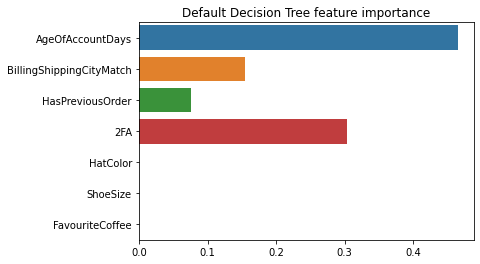

In [ ]:
plt.figure()
sns.barplot(x=model.feature_importances_, y=x_train.columns)
plt.title('Default Decision Tree feature importance')

Text(0.5, 1.0, 'Decision tree')

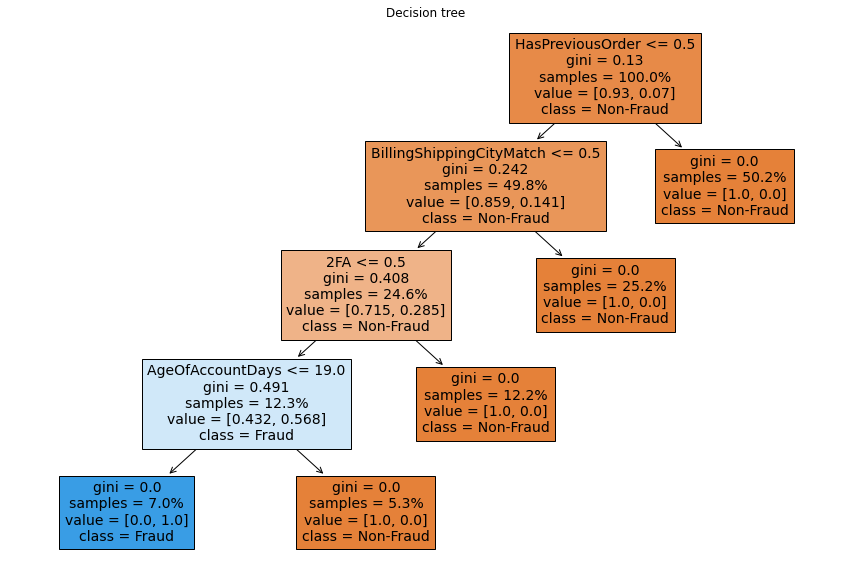

In [ ]:
plt.figure(figsize=(15,10))
_ = tree.plot_tree(model, feature_names=x_train.columns, class_names=['Non-Fraud', 'Fraud'], filled=True, proportion=True)
plt.title('Decision tree')

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
perm_importance = permutation_importance(model, x_train, y_train, n_repeats=30)

Text(0.5, 1.0, 'Permutation importance')

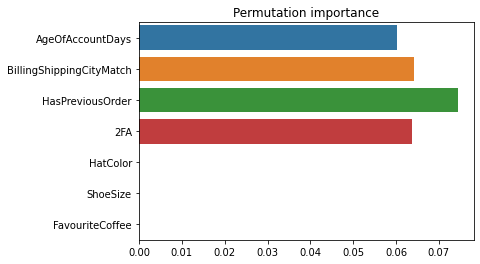

In [ ]:
plt.figure()
sns.barplot(x=perm_importance.importances_mean, y=x_train.columns)
plt.title('Permutation importance')

In [ ]:
perm_importance = permutation_importance(model, x_train.iloc[38:45], y_train.iloc[38:45], n_repeats=100)

# Global explanation

In [ ]:
explainer = shap.TreeExplainer(model, data=x_train)

In [ ]:
shap_vals = explainer.shap_values(x_train)

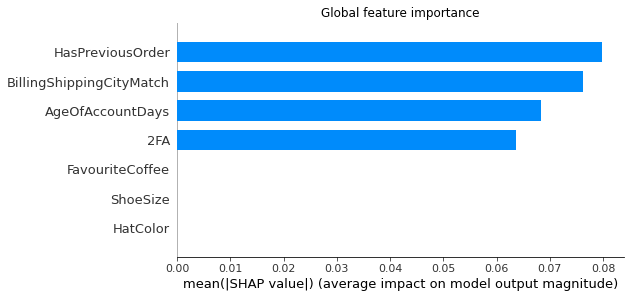

In [ ]:
plt.figure()
plt.title('Global feature importance')
shap.summary_plot(shap_vals[0], features=x_train.columns, plot_type='bar')

# Local explanation for 4 distinct samples

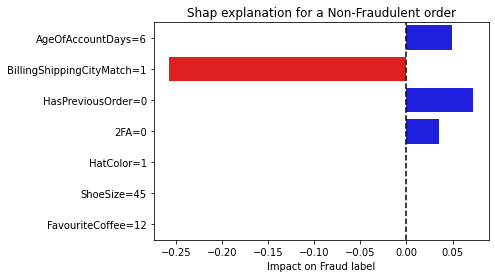

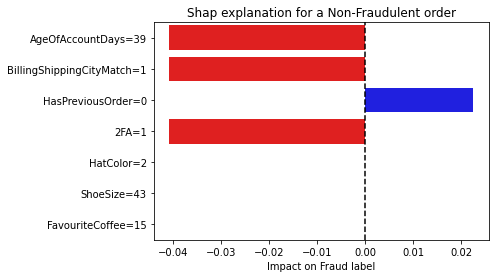

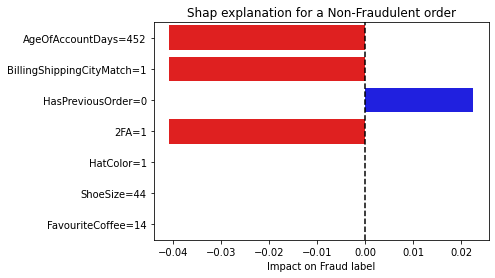

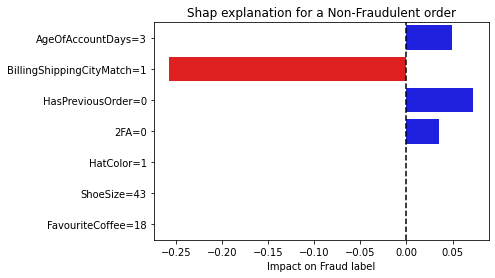

In [ ]:
def get_palette(shap_vals):
    palette = []
    for val in shap_vals > 0:
        if val:
            palette.append('b')
        else:
            palette.append('r')
    return palette


for i in range(84, 88):
    palette = get_palette(shap_vals[1][i])
    cols = []
    for j in range(7):
        cols.append(str(x_train.iloc[i].index[j]) + '=' + str(x_train.iloc[i].values[j]))
    
    plt.figure()
    if y_train.iloc[i] == 1:
        plt.title('Shap explanation for a Fraudulent order')
    else:
        plt.title('Shap explanation for a Non-Fraudulent order')
    sns.barplot(x=shap_vals[1][i], y=cols, palette=palette)
    plt.axvline(0, 0, linestyle='--', color='black')
    plt.xlabel('Impact on Fraud label')
    plt.show()

# Lime explanations

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, 
                                                   training_labels=y_train,  
                                                   feature_names=x_train.columns, 
                                                   class_names=['Not-Fraud', 'Fraud'], 
                                                   verbose=True)

In [ ]:
i=25
exp = explainer.explain_instance(x_test.iloc[i], model.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True)

Intercept 0.14603708700341733
Prediction_local [-0.06255497]
Right: 0.0


In [ ]:
i=36
exp = explainer.explain_instance(x_test.iloc[i], model.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True)

Intercept -0.007726422124898269
Prediction_local [0.17187722]
Right: 0.0
